In [1]:
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomBrightness, RandomFlip, RandomRotation, RandomContrast
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
print(tf.config.list_physical_devices('GPU'))

2024-07-06 21:00:12.993628: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 21:00:13.052861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 21:00:13.052910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 21:00:13.055280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 21:00:13.066654: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
IMG_SIZE = (112, 112)
BATCH_SIZE = 512

In [3]:
DATA_SET_PATH_TRAIN = '/home/jupyter/tpp/datasets/processed/cnn_pr'

In [4]:
#image = plt.imread(DATA_SET_PATH_TRAIN + '/Anger/affwild_pr_9-15-1920x1080_28357.jpg')
#resized_image = Image.fromarray(image).resize(IMG_SIZE)
#plt.imshow(resized_image)
#plt.show()

In [5]:
emociones = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'] #train_dataset.info
emociones

['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

In [7]:
train_dataset = image_dataset_from_directory(DATA_SET_PATH_TRAIN + '/Train_Set_v2',
                                             shuffle=True,
                                             label_mode='categorical',     
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.8,
                                             subset='training',
                                             image_size=IMG_SIZE,
                                             seed=32)

validation_dataset = image_dataset_from_directory(DATA_SET_PATH_TRAIN + '/Train_Set_v2',
                                             shuffle=True, 
                                             label_mode='categorical', 
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             image_size=IMG_SIZE,
                                             seed=32)

Found 1427186 files belonging to 7 classes.
Using 285438 files for training.


2024-07-06 21:01:22.647191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Found 1427186 files belonging to 7 classes.
Using 285437 files for validation.


In [6]:
train_dataset = image_dataset_from_directory(DATA_SET_PATH_TRAIN + '/Train_Set_v2',
                                             shuffle=True,
                                             label_mode='categorical',     
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(DATA_SET_PATH_TRAIN + '/Validation_Set',
                                             shuffle=True, 
                                             label_mode='categorical', 
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1427186 files belonging to 7 classes.


2024-06-27 13:45:57.131970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Found 200072 files belonging to 7 classes.


In [8]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomBrightness(factor=0.4))
    data_augmentation.add(RandomContrast(0.4))
    ### END CODE HERE
    
    return data_augmentation

In [11]:
len(emociones)

7

In [12]:
# Keras mapea las carpetas por orden alfabetico cuando arma el dataset
class_names = dict(enumerate(emociones))
class_names

{0: 'Anger',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happiness',
 4: 'Neutral',
 5: 'Sadness',
 6: 'Surprise'}

# Count weights

In [13]:
## Crear un diccionario para almacenar la cantidad de muestras en cada clase
class_counts = {}

# Contar la cantidad de muestras en cada clase
for _, labels in train_dataset:
    for label in labels:
        class_index = tf.argmax(label).numpy()  # Obtener el índice de la clase con el valor más alto
        if class_index not in class_counts:
            class_counts[class_index] = 1
        else:
            class_counts[class_index] += 1

# Imprimir la cantidad de muestras en cada clase
for class_index, count in class_counts.items():
    print(f'Clase "{class_index}": {count} muestras')

Clase "0": 37168 muestras
Clase "3": 62124 muestras
Clase "6": 27035 muestras
Clase "5": 55806 muestras
Clase "4": 84560 muestras
Clase "2": 14006 muestras
Clase "1": 4739 muestras


In [20]:
## UNQ_C2
# GRADED FUNCTION
def vgg16_emotion_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    print('Input shape:', input_shape)
    ### START CODE HERE

    #MobileNetV2
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    print("Number of layers in the base model:", len(base_model.layers))

    # freeze all layers by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) #working with black&white images
   
    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)
    
    # preprocess_input data using the same weights the model was trained on
    # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    x = tfl.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(.2)(x)
    x = tfl.Dense(1024, activation='relu')(x)
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=len(emociones), activation='softmax')(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [21]:
data_augmentation = data_augmenter()
model2 = vgg16_emotion_model(IMG_SIZE, data_augmentation)

Input shape: (112, 112, 3)
Number of layers in the base model: 19


In [22]:
base_learning_rate = 0.001

In [23]:
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
               metrics=[tf.keras.metrics.F1Score(name='f1_score'), 
                        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'), 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

In [24]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 112, 112, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [25]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs) #class_weight=class_weights)

Epoch 1/5
558/558 [==============================] - 103s 182ms/step - loss: 1.7326 - f1_score: 0.2740 - categorical_accuracy: 0.3619 - precision: 0.4943 - recall: 0.1650 - val_loss: 1.4230 - val_f1_score: 0.3722 - val_categorical_accuracy: 0.4467 - val_precision: 0.7076 - val_recall: 0.2000
Epoch 2/5
558/558 [==============================] - 101s 181ms/step - loss: 1.4758 - f1_score: 0.3314 - categorical_accuracy: 0.4197 - precision: 0.6712 - recall: 0.1773 - val_loss: 1.3562 - val_f1_score: 0.3825 - val_categorical_accuracy: 0.4752 - val_precision: 0.7264 - val_recall: 0.2318
Epoch 3/5
558/558 [==============================] - 101s 181ms/step - loss: 1.4226 - f1_score: 0.3581 - categorical_accuracy: 0.4405 - precision: 0.7046 - recall: 0.1999 - val_loss: 1.3316 - val_f1_score: 0.4129 - val_categorical_accuracy: 0.4825 - val_precision: 0.7759 - val_recall: 0.2295
Epoch 4/5
558/558 [==============================] - 102s 181ms/step - loss: 1.3902 - f1_score: 0.3757 - categorical_accu

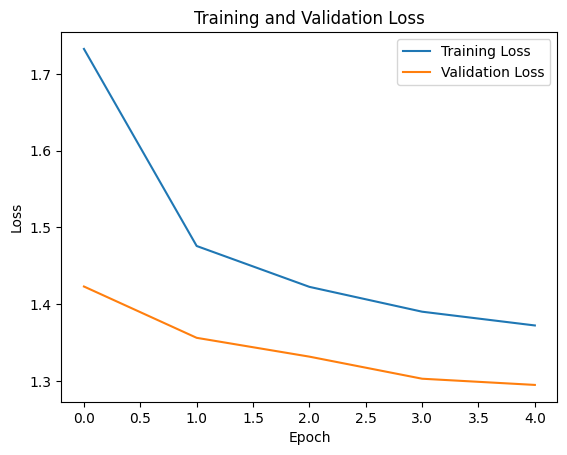

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar pérdida
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

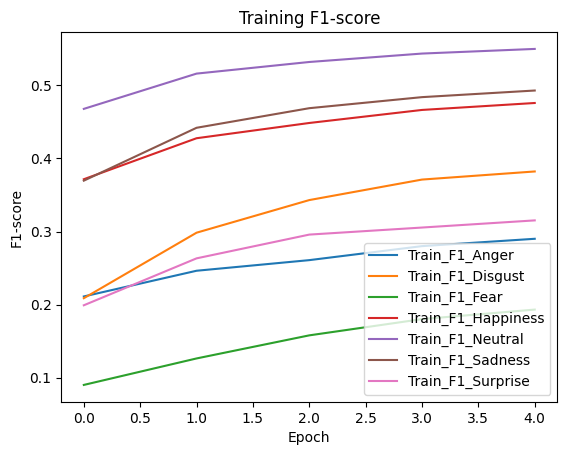

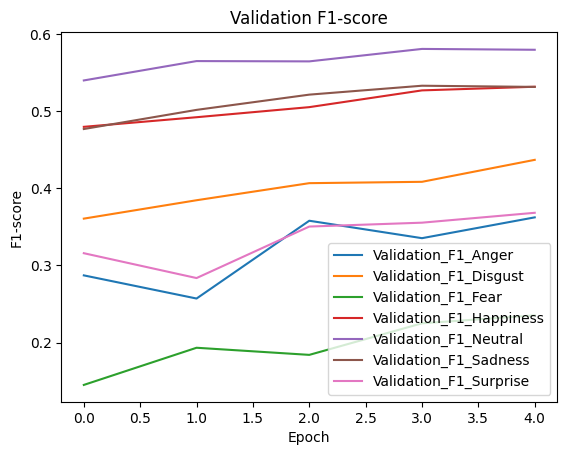

In [27]:
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

if not hasattr(train_f1, "__len__"):
    # Graficar pérdida
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.title('Training and Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    # Graficar F1-score
    plt.plot(train_f1, label=['Train_F1_'+ v for v in emociones])
    plt.title('Training F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.show()

    # Graficar F1-score
    plt.plot(val_f1, label=['Validation_F1_'+ v for v in emociones])
    plt.title('Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.show()

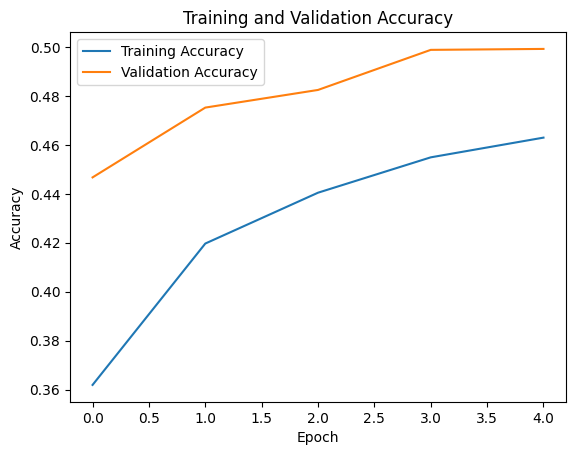

In [28]:
# Obtener métricas de entrenamiento
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']


# Graficar precisión
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

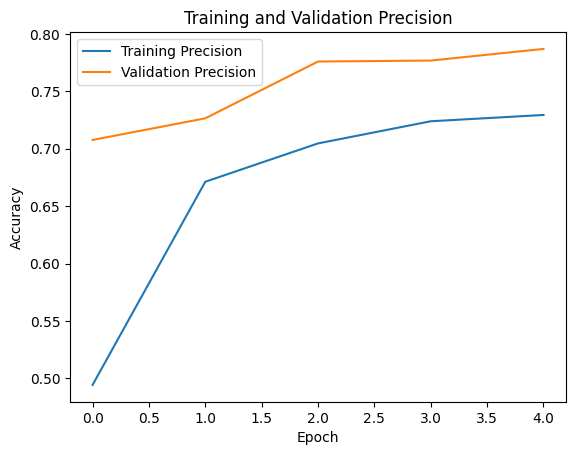

In [29]:
# Obtener métricas de entrenamiento
train_precision = history.history['precision']
val_precision = history.history['val_precision']


# Graficar precisión
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

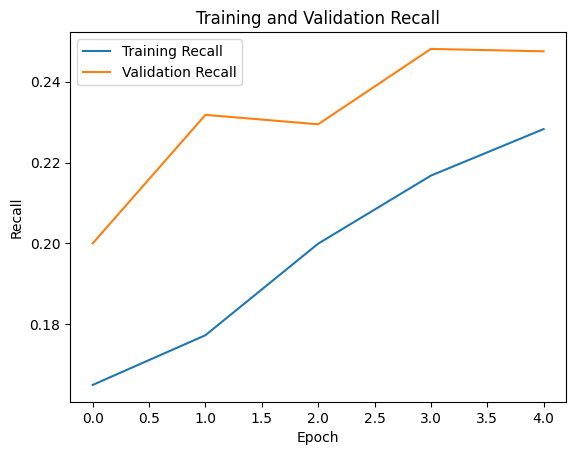

In [30]:
# Obtener métricas de recall y F1-score
train_recall = history.history['recall']
val_recall = history.history['val_recall']


# Graficar recall
plt.plot(train_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Fine tunning model VGG

In [31]:
model2.layers

In [32]:
# UNQ_C3
base_model = model2.layers[3] #make trainable the 4th block
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  19


In [33]:
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy()
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=.1*base_learning_rate)

model2.compile(loss=loss_function,
                optimizer = optimizer,
               metrics=[tf.keras.metrics.F1Score(name='f1_score'), 
                        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'), 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

In [34]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
                         #class_weight=class_weights)

Epoch 5/10
558/558 [==============================] - 101s 173ms/step - loss: 1.2272 - f1_score: 0.4461 - categorical_accuracy: 0.5301 - precision: 0.7525 - recall: 0.3234 - val_loss: 1.0268 - val_f1_score: 0.5307 - val_categorical_accuracy: 0.6174 - val_precision: 0.7691 - val_recall: 0.4632
Epoch 6/10
558/558 [==============================] - 96s 172ms/step - loss: 1.0754 - f1_score: 0.5137 - categorical_accuracy: 0.5953 - precision: 0.7784 - recall: 0.4197 - val_loss: 0.9117 - val_f1_score: 0.5853 - val_categorical_accuracy: 0.6644 - val_precision: 0.8077 - val_recall: 0.5149
Epoch 7/10
558/558 [==============================] - 96s 171ms/step - loss: 0.9873 - f1_score: 0.5559 - categorical_accuracy: 0.6315 - precision: 0.7921 - recall: 0.4776 - val_loss: 0.8394 - val_f1_score: 0.6282 - val_categorical_accuracy: 0.6925 - val_precision: 0.8126 - val_recall: 0.5704
Epoch 8/10
558/558 [==============================] - 96s 172ms/step - loss: 0.9218 - f1_score: 0.5869 - categorical_acc

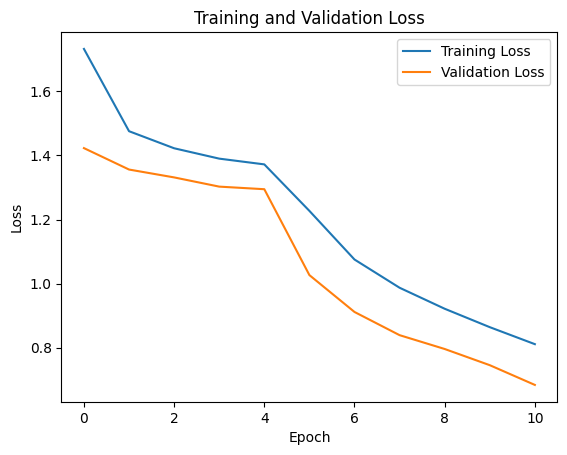

In [35]:
train_loss_f = train_loss + history_fine.history['loss']
val_loss_f = val_loss + history_fine.history['val_loss']

# Graficar pérdida
plt.plot(train_loss_f, label='Training Loss')
plt.plot(val_loss_f, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Anger -> Train: 0.5817 - Val: 0.6603
Disgust -> Train: 0.5563 - Val: 0.5852
Fear -> Train: 0.4822 - Val: 0.5929
Happiness -> Train: 0.7635 - Val: 0.8063
Neutral -> Train: 0.7374 - Val: 0.7864
Sadness -> Train: 0.7587 - Val: 0.8138
Surprise -> Train: 0.5879 - Val: 0.6345
F1 Score Macro TRAIN: 0.6382
F1 Score Macro VAL: 0.6971


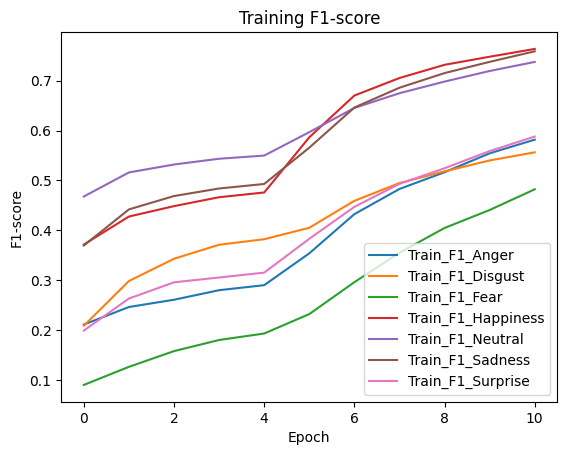

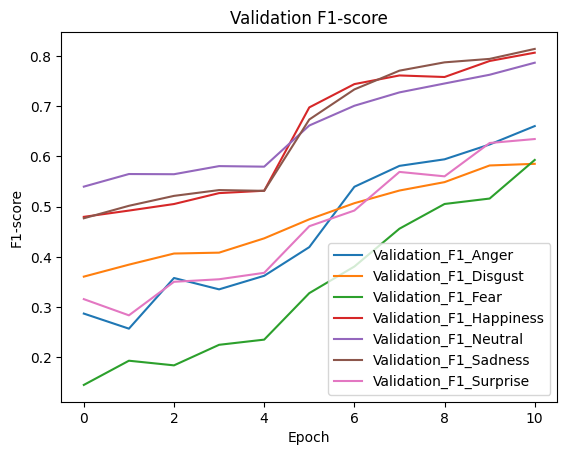

In [36]:
train_f1_f = train_f1 + history_fine.history['f1_score']
val_f1_f = val_f1 + history_fine.history['val_f1_score']


if not hasattr(train_f1_f, "__len__"):
    # Graficar pérdida
    plt.plot(train_f1_f, label='Training F1')
    plt.plot(val_f1_f, label='Validation F1')
    plt.title('Training and Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    for emocion, v_train, v_val in zip(emociones, train_f1_f[-1], val_f1_f[-1]):
        print(f"{emocion} -> Train: {v_train:.4f} - Val: {v_val:.4f}")

    
    # F1 SCORE MACRO
    f1_score_macro_train = np.mean(train_f1_f[-1])
    print(f'F1 Score Macro TRAIN: {f1_score_macro_train:.4f}')
    f1_score_macro_val = np.mean(val_f1_f[-1])
    print(f'F1 Score Macro VAL: {f1_score_macro_val:.4f}')

    # Graficar F1-score
    plt.plot(train_f1_f, label=['Train_F1_'+ v for v in emociones])
    plt.title('Training F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.show()

    # Graficar F1-score
    plt.plot(val_f1_f, label=['Validation_F1_'+ v for v in emociones])
    plt.title('Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.show()

Train: 0.7026 - Val: 0.7573


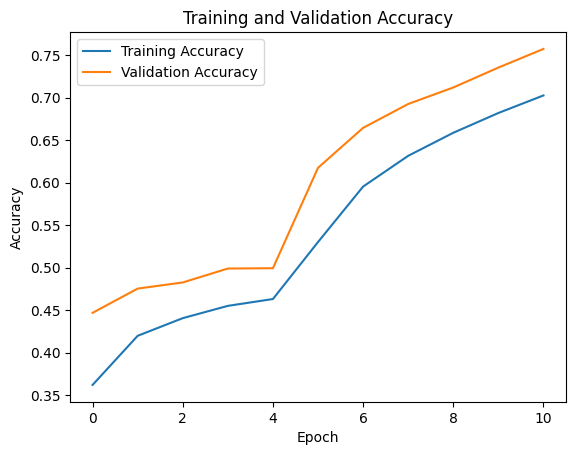

In [37]:
train_acc_f = train_acc + history_fine.history['categorical_accuracy']
val_acc_f = val_acc + history_fine.history['val_categorical_accuracy']
print(f"Train: {train_acc_f[-1]:.4f} - Val: {val_acc_f[-1]:.4f}")

# Graficar precisión
plt.plot(train_acc_f, label='Training Accuracy')
plt.plot(val_acc_f, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Train: 0.8226 - Val: 0.8223


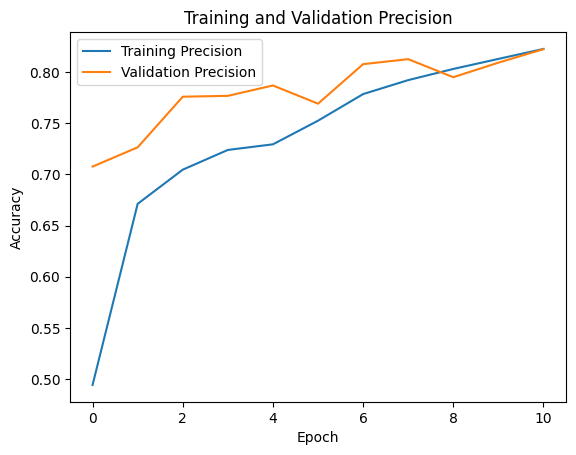

In [38]:
# Obtener métricas de entrenamiento
train_precision_f = train_precision + history_fine.history['precision']
val_precision_f = val_precision + history_fine.history['val_precision']
print(f"Train: {train_precision_f[-1]:.4f} - Val: {val_precision_f[-1]:.4f}")

# Graficar precisión
plt.plot(train_precision_f, label='Training Precision')
plt.plot(val_precision_f, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Recall: 0.5921 - Val: 0.6988


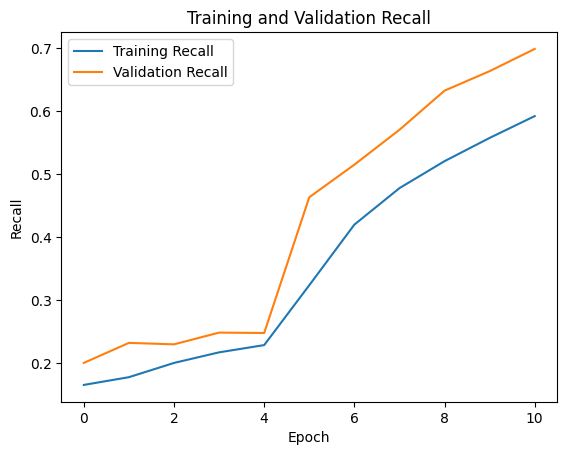

In [39]:
# Obtener métricas de recall y F1-score
train_recall_f = train_recall + history_fine.history['recall']
val_recall_f = val_recall + history_fine.history['val_recall']
print(f"Recall: {train_recall_f[-1]:.4f} - Val: {val_recall_f[-1]:.4f}")

# Graficar recall
plt.plot(train_recall_f, label='Training Recall')
plt.plot(val_recall_f, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [35]:
MODELS_PATH = "../Modelos/"

def export_model(model, name):
    json_string = model.to_json()
    model.save_weights(MODELS_PATH + name +'.h5')
    open(MODELS_PATH + name + '.json', 'w').write(json_string)

In [36]:
export_model(model2, 'vgg16_cota_112_wieghts')

In [ ]:
model2

In [32]:
model2.save('../Modelos/cotatest_v2.keras')

# Predictions

In [25]:
from keras.models import model_from_json, Sequential, load_model
from keras.src.saving import serialization_lib


serialization_lib.enable_unsafe_deserialization()

MODELS_PATH = "../Modelos/"
cnn_model_name = "vgg16_cota_112_wieghts.keras"

def load_model_keras():
    model = load_model(MODELS_PATH + cnn_model_name)
    return model

In [26]:
cnn_model = load_model_keras()

In [27]:
dataset = validation_dataset

In [ ]:
# Hacer predicciones en los datos de validación en lotes
predictions = []
true_labels = []

for images, labels in dataset:
    batch_predictions = cnn_model.predict(images)
    predictions.extend(batch_predictions)
    true_labels.extend(labels)
    
predictions = tf.convert_to_tensor(predictions)
true_labels = tf.convert_to_tensor(true_labels)

In [29]:
predicted_labels = [class_names[v] for v in np.argmax(predictions, axis=1)]
print(np.argmax(predictions, axis=1)[5:10])
predicted_labels[5:10]

[4 3 3 4 4]


['Neutral', 'Happiness', 'Happiness', 'Neutral', 'Neutral']

In [39]:
i = 0
for idx, path in enumerate(dataset.file_paths):
    
    if path.split('/')[-2] == 'Disgust':
        i += 1
        if(i == 1100):
            print(path, idx)
            break

/home/jupyter/tpp/datasets/processed/cnn_pr/Validation_Set/Disgust/6-30-1920x1080_right_04494.jpg 44191


In [31]:
true_labels = [path.split('/')[-2] for path in dataset.file_paths]
true_labels[5:10]

['Surprise', 'Surprise', 'Happiness', 'Neutral', 'Sadness']

/home/jupyter/tpp/datasets/processed/cnn_pr/Validation_Set/Disgust/6-30-1920x1080_right_04494.jpg
True emotion: Disgust
Predicted emotion: Happiness
Predicted array: tf.Tensor(
[2.2779426e-03 2.1748762e-03 6.4060754e-05 6.7855310e-01 3.1254029e-01
 1.5113580e-03 2.8783923e-03], shape=(7,), dtype=float32)


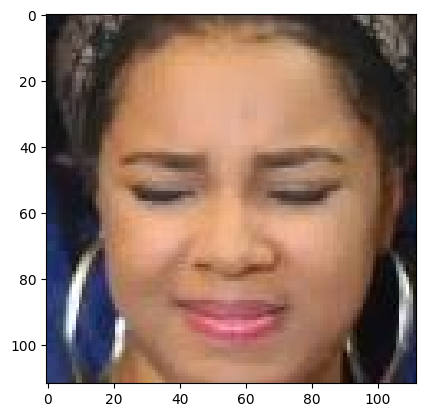

In [40]:
image_index = 44191
image_path = dataset.file_paths[image_index]

print(image_path)
print('True emotion:', true_labels[image_index])
print('Predicted emotion:', predicted_labels[image_index])
print('Predicted array:', predictions[image_index])

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

In [33]:
import cv2

In [34]:
frame = cv2.imread('/home/jupyter/tpp/14483_00025_crop.jpg')
img = np.reshape(frame, (112, 112, 3))
img = np.expand_dims(img, axis=0)

In [35]:
[class_names[v] for v in np.argmax(cnn_model.predict(img), axis=1)]

1/1 [==============================] - 1s 590ms/step


['Happiness']

In [36]:
cnn_model.predict(img)

1/1 [==============================] - 0s 29ms/step


array([[9.2158814e-05, 2.7782684e-03, 2.0617351e-03, 9.8596942e-01,
        3.4157885e-04, 3.1768968e-03, 5.5799065e-03]], dtype=float32)

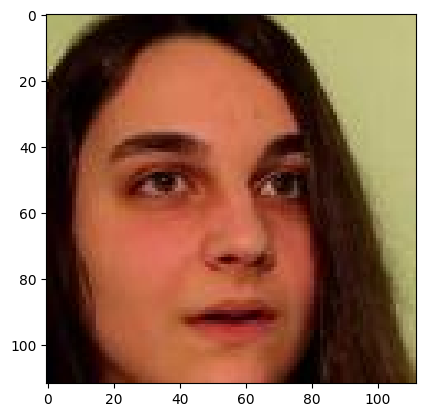

In [17]:
image = plt.imread('/home/jupyter/tpp/datasets/processed/cnn_pr/Train_Set_v2/Disgust/video73_04240.jpg')
plt.imshow(image)
plt.show()